In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys, os
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn import metrics


from pathlib import Path
import joblib


In [3]:
# currentdir = os.path.abspath(os.getcwd())
# parentdir = os.path.dirname(currentdir)
# print(parentdir)
# sys.path.insert(0, parentdir) 

# from torchvision.io import read_image

# from torch.nn import DataParallel  # TODO: switch to DistributedDataParallel
from torch.utils.data import DataLoader

# from get_embedding import get_images_labels_features, get_emb_model, get_images
# from misc.embeddings import write_embedding, overwrite_embedding_classes

# from dataloader.train_loader import MoNuSegDataset
# from dataloader.utils import get_file_list

# from models.hovernet.targets import gen_targets


## Cluster fucntions

In [4]:
from util import ClusterModel, exp_cluster

### Embedding transform


In [5]:
from util import get_embeddings

In [6]:
import sys
sys.path.append('/workspace/patchcore-inspection/src')
sys.path.append('/workspace/patchcore-inspection/')
from patchcore.datasets.monuseg import get_monuseg_images, MoNuSegDataset

input_path = "/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128"

data_dirs = {
    os.path.join(input_path, "MoNuSegTrainingData/images") : os.path.join(input_path, "MoNuSegTrainingData/images"),
    os.path.join(input_path, "MoNuSegTestData/images") : os.path.join(input_path, "MoNuSegTestData/images"),
}

images = {k : get_monuseg_images('', [v], subsample=None) for k, v in data_dirs.items()}


In [7]:
images

{'/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images': ['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-HE-7130-01Z-00-DX1_002.png',
  '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-G9-6362-01Z-00-DX1_025.png',
  '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-21-5786-01Z-00-DX1_018.png',
  '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-AY-A8YK-01A-01-TS1_034.png',
  '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-HE-7130-01Z-00-DX1_014.png',
  '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-MH-A561-01Z-00-DX1_004.png',
  '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images/TCGA-UZ-A9PN-01Z-00-DX1_029.png',
  '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTraining

In [32]:
from feature_extractor.utils import extract_features
import json, os
import numpy as np
import torch

# backbone = "medsam"
# backbone = "optimus_old"
backbone = "resnet50"
# backbone = "optimus"

layer = "out"


# embedding_path = os.path.join('./logs_clustered/MoNuSeg/patches_valid_inst_128x128_128x128', f"{PREPROCESS}_{EMB_MODEL_NAME}")

features_dict = {}

for k, v in images.items():
    feat_path = k + f"_feat_{backbone}.json"
    if os.path.exists(feat_path):
        with open(feat_path, 'r') as f:
            feat_json = json.load(f)

            opt_feat_flat = [feat_json[i] for i in v]
            opt_feat_flat = np.array(list(opt_feat_flat))  

            print(feat_path, opt_feat_flat.shape)        

            features_dict[k] = opt_feat_flat

    else:
        raise NotImplementedError

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_features = extract_features(v, backbone, device=device, layers=[layer])
        
        img_feature_out = img_features[layer].squeeze()

        features_dict[k] = img_feature_out






/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images_feat_resnet50.json (2368, 2048)
/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images_feat_resnet50.json (896, 2048)


## Visualize features

In [33]:
len(images['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images'])

896

## Cluster features

In [34]:
print(features_dict.keys())

train_features = features_dict['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images']
test_features = features_dict['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images']

train_features.shape


dict_keys(['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images'])


(2368, 2048)

In [35]:
ind = np.random.choice(len(train_features), len(train_features), replace=False)
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
val_features = train_features[ind_val]
train_features = train_features[ind_train]

train_features.shape, val_features.shape

((2013, 2048), (355, 2048))

In [44]:
EMB_TRANSFORM = "umap"
emb_kwargs = dict(
    n_components= 3, 
    # random_state= 42,
)

# EMB_TRANSFORM = "pca"
# emb_kwargs = dict(
#     n_components= 3, 
#     random_state= 42,
# )


emb_txt = "_".join([f"{k}_{v}" for k,v in emb_kwargs.items()])

# scaled_train_features, scaled_val_features = get_embeddings(train_features, val_features, EMB_TRANSFORM, emb_kwargs=emb_kwargs)





In [45]:
EMB_TRANSFORM = "umap"
emb_kwargs = dict(
    n_components= 3, 
    # random_state= 42,
)


CLUSTER_MODEL_NAME = "hdbscan"
# cluster_model_kwargs = {}
# cluster_model_kwargs = dict(cluster_selection_epsilon=1e9, cluster_selection_method = 'eom')
# cluster_model_kwargs = dict(cluster_selection_epsilon=1, min_samples=5, min_cluster_size=50, allow_single_cluster=True)
cluster_model_kwargs = dict(min_samples=1, min_cluster_size=50)

# CLUSTER_MODEL_NAME = "kmeans"
# cluster_model_kwargs = dict(n_clusters=6, init='k-means++')

cluster_kwargs_txt = "_".join([f"{k}_{v}" for k,v in cluster_model_kwargs.items()])



# exp_out = exp_cluster(CLUSTER_MODEL_NAME, cluster_model_kwargs, scaled_train_features, scaled_val_features, val_features=val_features)
exp_out = exp_cluster(CLUSTER_MODEL_NAME, cluster_model_kwargs, train_features=train_features, val_features=val_features, reducer=EMB_TRANSFORM, emb_kwargs=emb_kwargs, iterations=3)
# best_model = exp_out.pop('model_best')

# train_clusters = best_model.predict(scaled_train_features)
# val_clusters = best_model.predict(scaled_val_features)

# train_clusters = exp_out.pop('train_clusters')
# val_clusters = exp_out.pop('val_clusters')



  0%|          | 0/3 [00:00<?, ?it/s]

Running reducer...
[-1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1
 -1 -1  1  0 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1
 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1  0  1 -1 -1 -1  1
 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1 -1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  0
 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1
 -1 -1 -1  1 -1 -1 -1  1 -1  0 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  0  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1
 -1 -1  1 -1  1 -1 -1  1  1 -1 -

 33%|███▎      | 1/3 [00:09<00:18,  9.36s/it]

-0.06087084996536806
Running reducer...
[-1 -1  6 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5  1  6 -1 -1 -1 -1
 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1
  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1  3  3 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  0 -1 -1 -1 -1 -1  8  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  7 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1
 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  5 -1 -1  5 -1 -1
 -1 -1 -1 -

 33%|███▎      | 1/3 [00:18<00:36, 18.38s/it]


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
print(exp_out[['sil_score', 'dbcv_score', 'mx_size', 'mn_size']])

   sil_score  dbcv_score   mx_size   mn_size
2  -0.170017    0.061362  0.537506  0.218082
1  -0.226261   -0.021191  0.631893  0.181321
0  -0.260657    0.041586  0.676602  0.150025


In [42]:
print(exp_out.keys())
# print(exp_out["train_clusters"])
for i in range(len(exp_out["train_clusters"])):
    train_clusters = exp_out["train_clusters"].iloc[i]
    val_clusters = exp_out["val_clusters"].iloc[i]

    u, cnt = np.unique(train_clusters, return_counts=True)
    print('\t'.join(map(str, u)))
    print('\t'.join(map(str, cnt)))

    print('\t'.join(map(str, map(lambda x : list(val_clusters).count(x), u))))
    print()


Index(['models', 'sil_score', 'dbcv_score', 'mx_size', 'mn_size',
       'train_clusters', 'val_clusters'],
      dtype='object')
-1	0	1
1082	492	439
309	26	20

-1	0	1
1272	376	365
326	15	14

-1	0	1
1362	349	302
335	16	4



<Axes: ylabel='$\\lambda$ value'>

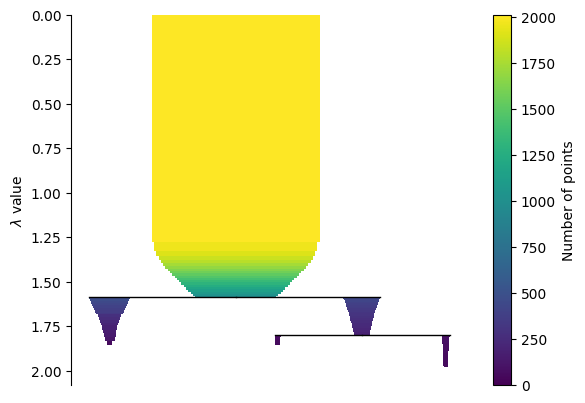

In [43]:
best_model = exp_out["models"].iloc[0]
best_model.model.cluster_selection_epsilon

condensed_tree = best_model.model.condensed_tree_
condensed_tree.plot()

In [39]:
tree = condensed_tree.to_numpy()
print(tree)

[(2013, 2014, 0.07991874, 1634) (2013, 2015, 0.07991874,  379)
 (2014, 2016, 0.0901928 , 1087) ... (2076, 1210, 6.03925528,    1)
 (2076,  868, 6.03925528,    1) (2076, 1978, 6.03925528,    1)]


<Axes: ylabel='distance'>

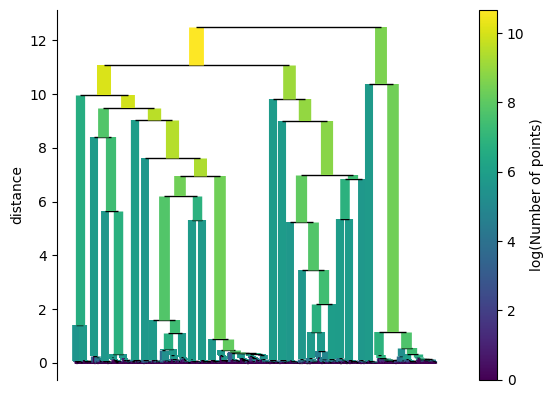

In [34]:
single_linkage_tree.plot(cmap='viridis', colorbar=True)


In [31]:
single_linkage_tree = best_model.model.single_linkage_tree_

tree = single_linkage_tree.to_numpy()

tree[:, 0].max(), tree[:, 1].max()

(4023.0, 4022.0)

In [32]:

par = exp_out["train_clusters"].iloc[0]

for i, j, dist, size in tree.tolist():
    i, j = int(i), int(j)
    print(i, j, dist)
    print(par[i], par[j], )
    


1451 1735 0.0011379504986026852
17 17
522 1146 0.0012924860481362138
5 5
821 1708 0.0013009517916284235
15 15
165 468 0.0014380321102668609
15 15
674 2015 0.0014462052217212513


IndexError: index 2015 is out of bounds for axis 0 with size 2013

In [53]:
import scipy.spatial.distance

ind1, ind2, dist1, _ = tree[0]
print(ind1, ind2, dist1)

p1, p2 = train_features[int(ind1)], train_features[int(ind2)]

dist_ = scipy.spatial.distance.cdist(p1.reshape(-1, 1), p2.reshape(-1, 1)).sum()

print(dist_)


1146.0 1945.0 0.002572277898958791
2090550.3867423132


In [59]:
import sklearn.datasets
from dbcv import dbcv
from sklearn.preprocessing import StandardScaler

X, y = sklearn.datasets.make_moons(n_samples=300, noise=0.05, random_state=1782)
y[0] = -1

print(train_features.max(), train_features.min())
print(X.max(), X.min())

if False:
    X = train_features
    y = np.random.randint(-1, 3, len(train_features), dtype=np.int64)
    X, scaled_val_features = get_embeddings(train_features, val_features, EMB_TRANSFORM, emb_kwargs=emb_kwargs)

print(X.shape, y.shape)
# print(y)
print(X.min(), X.max())
print(y.min(), y.max())
score = dbcv(X, y)
print(score)


4.661314487457275 -4.672053337097168
2.0778909634001472 -1.0717697807092257
(300, 2) (300,)
-1.0717697807092257 2.0778909634001472
-1 1
[[1.80908879e-02]
 [5.91018945e-03]
 [3.33577791e-02]
 [1.58415874e-02]
 [6.14728555e-04]
 [1.56762439e-02]
 [6.32747379e-03]
 [4.85254805e-02]
 [2.99120510e-02]
 [5.99633859e-04]
 [3.25217293e-02]
 [3.29838180e-03]
 [3.18374047e-03]
 [7.99851118e-03]
 [6.58807556e-03]
 [7.30719139e-03]
 [1.41056484e-02]
 [3.21350435e-03]
 [5.28602106e-03]
 [1.80761027e-02]
 [1.44829340e-02]
 [3.72227522e-03]
 [6.90245627e-03]
 [1.77971716e-02]
 [5.26716020e-03]
 [3.78329532e-03]
 [6.11892320e-05]
 [2.45562971e-03]
 [6.03345396e-03]
 [6.07450981e-03]
 [9.76887226e-04]
 [1.16512323e-03]
 [6.19110347e-03]
 [4.28807382e-03]
 [6.00721627e-04]
 [5.74942170e-04]
 [9.92074704e-03]
 [3.00300712e-02]
 [6.06735448e-03]
 [2.36015421e-02]
 [5.30521273e-02]
 [1.15461996e-03]
 [1.59056418e-02]
 [3.16395503e-02]
 [1.71898247e-02]
 [7.30241196e-03]
 [1.42626344e-02]
 [5.18856237e-03]


0.8091730609641868


-1	0	1
258	1305	805
344	77	475


In [ ]:
EMB_TRANSFORM = "umap"
emb_kwargs = dict(
    n_components= 2, 
    random_state= 42,
)

# emb_txt = "_".join([f"{k}_{v}" for k,v in emb_kwargs.items()])

scaled_train_features, scaled_val_features = get_embeddings(train_features, val_features, EMB_TRANSFORM, emb_kwargs=emb_kwargs)


/root/miniconda3/envs/anomaly_detection/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


-1 64 0 -1
0 192 0 -1
1 192 0 -1
2 512 711 2
3 128 1 -1
4 448 23 4
5 192 97 5
6 256 57 6
7 192 4 -1
8 192 3 -1


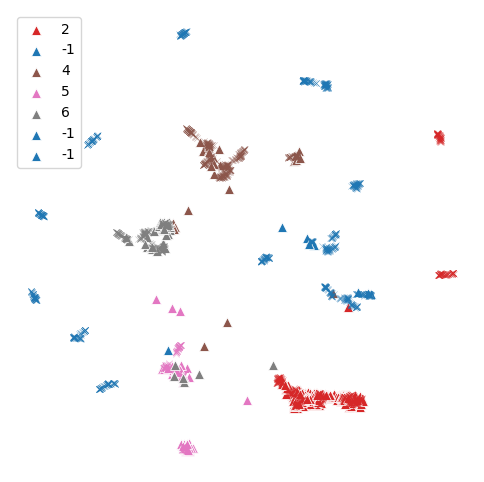

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i, iu in enumerate(u):
    ind = np.array(train_clusters) == iu
    ind_val = np.array(val_clusters) == iu
    if iu == 5 or sum(ind) > 200:
        col = f'C{i}'
        label = iu
    else:
        col = 'C0'
        label = -1
    print(iu, sum(ind), sum(ind_val), label)

    # col = 'C0' if sum(ind)<200 and iu!=5 else f'C{i}'
    # label=f'{-1 if sum(ind)<200 and iu!=5 else iu}'
    sns.scatterplot(x = scaled_val_features[ind_val, 0], y= scaled_val_features[ind_val, 1], c=col, ax=ax, marker='^', s=50, label=label)
    sns.scatterplot(x = scaled_train_features[ind, 0], y= scaled_train_features[ind, 1], c=col, ax=ax, marker='x', s=20, alpha=.5)

# sns.scatterplot(x = scaled_syn_features[:, 0], y= scaled_syn_features[:, 1], c=f'C{i}', ax=ax, marker='.', s=5)

# labels = ['gt_test', 'gt_train']
# labels += ['syn_train_clus6']
# ax.legend('')
ax.axis('off')
# ax.legend()


plt.show()


In [ ]:
PREPROCESS = '_'
exp_name = 'v1.3'
out_path = f"/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/{PREPROCESS}_{backbone}_{EMB_TRANSFORM}_{emb_txt}_{CLUSTER_MODEL_NAME}_{cluster_kwargs_txt}_{exp_name}"
print(out_path)


/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__optimus_umap_n_components_5_hdbscan_min_samples_50_min_cluster_size_100_v1.3


In [ ]:
from util import cluster_to_json, save_cluster_model

In [ ]:
train_file_names = images['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTrainingData/images']
val_file_names = images['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/MoNuSegTestData/images']


In [ ]:
print(train_clusters)

[0 4 8 ... 7 6 4]


In [ ]:
if out_path is not None:

    if not os.path.exists(os.path.join(out_path, "train.json")):
        save_cluster_model(best_model, os.path.join(out_path, "model.joblib"))
        cluster_to_json(train_file_names, train_clusters, out_path, "train.json")
        cluster_to_json(val_file_names, val_clusters, out_path, "valid.json")

    if exp_out is not None:
        print(exp_out)
        with open(os.path.join(out_path, "exp.json"), "w+") as f:
            json.dump(exp_out, f)


ValueError: too many values to unpack (expected 2)

In [ ]:
# PREPROCESS = "color_rand"
PREPROCESS = "_"

backbone = "optimus"

EMB_TRANSFORM = "umap"
emb_kwargs = dict(
    n_components= 3, 
    random_state= 42,
)

# EMB_TRANSFORM = "pca"
# emb_kwargs = dict(
#     n_components= 3, 
#     random_state= 42,
# )

emb_txt = "_".join([f"{k}_{v}" for k,v in emb_kwargs.items()])


# CLUSTER_MODEL_NAME = "kmeans"
# N_CLUSTERS = 10
# model_kwargs = {
#     "n_clusters" : N_CLUSTERS, 
#     "n_init" : 3,
# }

# CLUSTER_MODEL_NAME = "spectral"
# N_CLUSTERS = 10
# model_kwargs = {
#     "n_clusters" : N_CLUSTERS, 
#     "n_init" : 3,
# }

CLUSTER_MODEL_NAME = "hdbscan"
model_kwargs = dict(min_samples=10, min_cluster_size=50)

exp_name = "v1.2"
kwargs_txt = "_".join([f"{k}_{v}" for k,v in model_kwargs.items()])


size = 128
input_path = "/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128"
embedding_path = os.path.join('./logs_clustered/MoNuSeg/patches_valid_inst_128x128_128x128', f"{PREPROCESS}_{EMB_MODEL_NAME}")
out_path = f"/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/{PREPROCESS}_{EMB_MODEL_NAME}_{EMB_TRANSFORM}_{emb_txt}_{CLUSTER_MODEL_NAME}_{kwargs_txt}_{exp_name}"
# out_path = f"/mnt/dataset/MoNuSeg/patches_valid_inst_256x256_128x128/{EMB_MODEL_NAME}_{EMB_TRANSFORM}_{emb_txt}_{CLUSTER_MODEL_NAME}_{kwargs_txt}_{exp_name}"
print(out_path)


## Feature extraction
if LOG_DIR is not None and os.path.exists(Path(LOG_DIR)/'train') and os.path.exists(Path(LOG_DIR)/'valid'):
    train_labels = pd.read_csv(Path(LOG_DIR)/'train'/'metadata.tsv' ,sep='\t', header=None)[0].to_list()
    train_features = pd.read_csv(Path(LOG_DIR)/'train'/'features.tsv' ,sep='\t', header=None).to_numpy()
    train_file_names = pd.read_csv(Path(LOG_DIR)/'train'/'paths.tsv' ,sep='\t', header=None)
    train_file_names = train_file_names[0].to_list(), train_file_names[1].to_list()
    train_images = get_images(train_file_names[0])

    val_labels = pd.read_csv(Path(LOG_DIR)/'valid'/'metadata.tsv' ,sep='\t', header=None)[0].to_list()
    val_features = pd.read_csv(Path(LOG_DIR)/'valid'/'features.tsv' ,sep='\t', header=None).to_numpy()
    val_file_names = pd.read_csv(Path(LOG_DIR)/'valid'/'paths.tsv' ,sep='\t', header=None)
    val_file_names = val_file_names[0].to_list(), val_file_names[1].to_list()
    val_images = get_images(val_file_names[0])
else:

    model_emb, preprocess = get_emb_model(EMB_MODEL_NAME)

    training_file_list = get_file_list([input_path + "/MoNuSegTrainingData"], ".png")
    valid_file_list = get_file_list([input_path + "/MoNuSegTestData"], ".png")

    # print("Dataset %s: %d" % (run_mode, len(file_list)))
    train_dataset = MoNuSegDataset(
        training_file_list, file_type=".png", mode="train", with_type=False, 
        target_gen=(None, None), input_shape=(size,size), mask_shape=(size,size))
    train_dataloader = DataLoader(train_dataset, num_workers= 8, batch_size= 8, shuffle=True, drop_last=False, )

    val_dataset = MoNuSegDataset(
        valid_file_list, file_type=".png", mode="valid", with_type=False, 
        target_gen=(None, None), input_shape=(size,size), mask_shape=(size,size))
    val_dataloader = DataLoader(val_dataset, num_workers= 8, batch_size= 8, shuffle=False, drop_last=False, )

    assert PREPROCESS == "_"        
    PREPROCESS_IMG = lambda x: x


    train_images, train_labels, train_features, train_file_names = get_images_labels_features(train_dataloader, model_emb, preprocess, PREPROCESS_IMG=PREPROCESS_IMG)
    val_images, val_labels, val_features, val_file_names = get_images_labels_features(val_dataloader, model_emb, preprocess, PREPROCESS_IMG=PREPROCESS_IMG)

    write_embedding(Path(LOG_DIR)/'train', train_images, train_features, train_labels, paths=train_file_names)
    write_embedding(Path(LOG_DIR)/'valid', val_images, val_features, val_labels, paths=val_file_names)
    write_embedding(Path(LOG_DIR)/'combined', train_images + val_images, list(train_features) + list(val_features),  train_labels + val_labels, paths=train_file_names + val_file_names)

scaled_train_features, scaled_val_features = get_embeddings(train_features, val_features, EMB_TRANSFORM)

## Clustering
if out_path is not None and os.path.exists(os.path.join(out_path, "model.joblib")):

    best_model = joblib.load(os.path.join(out_path, "model.joblib"))
    exp_out = None

    train_clusters = best_model.predict(scaled_train_features)
    val_clusters = best_model.predict(scaled_val_features)

else:
    exp_out = exp_cluster(CLUSTER_MODEL_NAME, model_kwargs, scaled_train_features, scaled_val_features, val_features=val_features)
    best_model = exp_out.pop('model')
    train_clusters = best_model.predict(scaled_train_features)
    val_clusters = best_model.predict(scaled_val_features)


# if LOG_DIR is not None:
#     write_embedding(Path(LOG_DIR)/'train', train_images, train_features, [f"{x}_train" for x in train_clusters], paths=train_file_names)
#     write_embedding(Path(LOG_DIR)/'valid', val_images, val_features, [f"{x}_val" for x in val_clusters], paths=val_file_names)
#     write_embedding(Path(LOG_DIR)/'combined', train_images + val_images, list(train_features) + list(val_features),  [f"{x}_train" for x in train_clusters] + [f"{x}_val" for x in val_clusters], paths=train_file_names + val_file_names)


if out_path is not None:

    if not os.path.exists(os.path.join(out_path, "train.json")):
        cluster_to_json(train_file_names, train_clusters, out_path, "train.json")
        cluster_to_json(val_file_names, val_clusters, out_path, "valid.json")
        save_cluster_model(best_model, os.path.join(out_path, "model.joblib"))

    if exp_out is not None:
        print(exp_out)
        with open(os.path.join(out_path, "exp.json"), "w+") as f:
            json.dump(exp_out, f)



In [ ]:
def write_feature(img_file, pil_images, features, labels, paths=None):
